# SIR model using a Physics Informed Neural Network.

## Goal
The goal of this notebook is the build a framework for solving 2 problems.
1. Use a PINN to train a neural network for predicting the development of a disease
2. Use the same framework to predict parameters for the disease. Such as the transfer rate.

## Numerical setup
Disease transmission can be modelled using a SIR model.

 $\frac{dS}{dt}=-\beta I S $
 
 $\frac{dI}{dt}= \beta I S - \alpha $
 
 $\frac{dR}{dt}= \alpha I$
 
This of differential equations has 3 variables. S which are people who are susceptible to the disease, I which are people who are infected with the disease, R for people who have recovered from the disease.

To govern the transfer from susceptible -> infected and from infected -> recovered are the parameters alpha and beta.
These are functions of the disease and of societal factors. Therefore these are often hard to find.

The framework used here will use data found from a numerical solution to the set of equations for some time. It will then predict into the future using the equations above. 
We will also not tell the network the true beta and alpha but use the optimizer to train these.

In [1]:
from scipy.integrate import solve_ivp
import torch
from torch import nn
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

from timeit import default_timer as tdt

from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt

#if torch.cuda.is_available():
if False:
    my_device = 'cuda' # I think I may have broken the cuda version
else:
    my_device = 'cpu'

### The settings for which we are trying to solve

In [2]:
# Time setup
n_days = 200
t_num = torch.linspace(0, n_days, 1001)

## Disease setup. These are the true values
alpha_SIR = 0.12
beta_SIR = 0.3

# The initial values for alpha and beta before the train on them.
beta_trainable_init =  0.125
alpha_trainable_init = 1.25

# Initial conditions
# 9.99999833e-01, 1.66666667e-07, 0.00000000e+00
N = 1.0    # Population size
I0_num = 1.66666667e-07
R0_num = 0.00000000e+00
S0_num = 1 - I0_num - R0_num    # Initial number of susceptible

# Datapoints
t_data_start = 0.0
t_data_end = 75.0

### Numerical solution

In [3]:
# Solve numerically
def SIR_model_num(t, y, beta_SIR, alpha_SIR):
    S, I, R = y
    dSdt = -beta_SIR * S * I
    dIdt = beta_SIR * S * I - alpha_SIR * I
    dRdt = alpha_SIR * I
    return [dSdt, dIdt, dRdt]

# Setup initial conditions 
y0 = [S0_num, I0_num, R0_num]

# Solve using LSODA method from scipy
sol = solve_ivp(SIR_model_num, [t_num[0], t_num[-1]], y0, args=(beta_SIR, alpha_SIR), t_eval=t_num, method='LSODA')

S_data = torch.tensor(sol.y[0])
I_data = torch.tensor(sol.y[1])
R_data = torch.tensor(sol.y[2])
#print(sol.message)

### Plotting the numerical solution

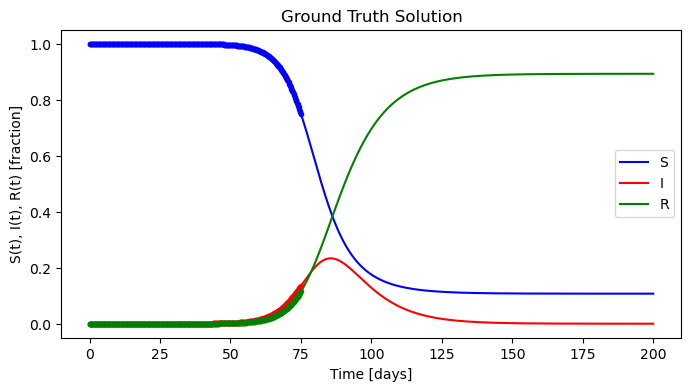

In [4]:
def plot_solution(t, S, I, R, title=''):
    t = t.clone().detach()
    S = S.clone().detach()
    I = I.clone().detach()
    R = R.clone().detach()
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.plot(t, S, label='S', color='blue')
    ax.plot(t, I, label='I', color='red')
    ax.plot(t, R, label='R', color='green')

    ax.set_xlabel('Time [days]')
    ax.set_ylabel('S(t), I(t), R(t) [fraction]')
    ax.legend()
    ax.set_title(title)
    
    return fig, ax
    
fig, ax = plot_solution(t_num, S_data, I_data, R_data, 'Ground Truth Solution')

# Picking some points
t_data_points = t_num[t_num >= t_data_start][t_num <= t_data_end]
S_data_points = S_data[t_num >= t_data_start][t_num <= t_data_end]
I_data_points = I_data[t_num >= t_data_start][t_num <= t_data_end]
R_data_points = R_data[t_num >= t_data_start][t_num <= t_data_end]
ax.plot(t_data_points, S_data_points, linestyle='', marker='.', color='blue')
ax.plot(t_data_points, I_data_points, linestyle='', marker='.', color='red')
ax.plot(t_data_points, R_data_points, linestyle='', marker='.', color='green')

### Plot which can run alongside training. Not currently used.

In [5]:
def monitor_plot():
    # Setup monitor plot that runs concurrently with training loop to illustrate: loss, adaptive weights, the network vs ground truth result
    # and in the bottom right the rhs of each equation and the derivative. These should of course be similar in a perfect world.
    fig, ax = plt.subplots(2, 2, figsize=(12,8))
    # Plot losses
    line_loss_total, = ax[0,0].plot([0.5,1], [0.5,1], color='k', label='Total Loss')
    line_loss_ode, = ax[0,0].plot([0.5,1], [0.5,1], color='red', label='ODE Loss', linestyle='--')
    line_loss_ic, = ax[0,0].plot([0.5,1], [0.5,1], color='blue', label='IC Loss', linestyle='--')
    line_loss_data, = ax[0,0].plot([0.5,1], [0.5,1], color='green', label='Data Loss', linestyle='--')
    ax[0,0].legend()
    ax[0,0].set_xlabel('Epochs')
    ax[0,0].set_ylabel('Loss')
    ax[0,0].set_yscale('log')

    # Plot ground truth next to solution from network
    ax[0,1].plot(t_num.detach(), S_data.detach(), color='blue', alpha=0.5, marker='', linestyle='-', label='S_truth')
    ax[0,1].plot(t_num.detach(), I_data.detach(), color='red', alpha=0.5, marker='', linestyle='-', label='I_truth')
    ax[0,1].plot(t_num.detach(), R_data.detach(), color='green', alpha=0.5, marker='', linestyle='-', label='R_truth')
    line_S, = ax[0,1].plot([0.5,1], [0.5,1], color='lightblue', linestyle='', label='S_net', marker='.')
    line_I, = ax[0,1].plot([0.5,1], [0.5,1], color='coral', linestyle='', label='I_net', marker='.')
    line_R, = ax[0,1].plot([0.5,1], [0.5,1], color='lightgreen', linestyle='', label='R_net', marker='.')
    ax[0,1].legend()
    ax[0,1].set_xlabel('Time [days]')
    ax[0,1].set_ylabel('S, I, R - (t)')

    # Adaptive weights plot
    line_aw0, = ax[1,0].plot([0.5,1], [0.5,1], color='red', linestyle='-', label='aw[0]')
    line_aw1, = ax[1,0].plot([0.5,1], [0.5,1], color='blue', linestyle='-', label='aw[1]')
    ax[1,0].set_ylabel('Adaptive Weights')
    ax[1,0].legend()
    
    # RHS and derivative plot
    line_dSdt, = ax[1,1].plot([0.5,1], [0.5,1], color='blue', linestyle='', label='dSdt', marker='.')
    line_dIdt, = ax[1,1].plot([0.5,1], [0.5,1], color='red', linestyle='', label='dIdt', marker='.')
    line_dRdt, = ax[1,1].plot([0.5,1], [0.5,1], color='green', linestyle='', label='dRdt', marker='.')

    line_RHS_S, = ax[1,1].plot([0.5,1], [0.5,1], color='lightblue', linestyle='', label='rhs_S', marker='.')
    line_RHS_I, = ax[1,1].plot([0.5,1], [0.5,1], color='coral', linestyle='', label='rhs_I', marker='.')
    line_RHS_R, = ax[1,1].plot([0.5,1], [0.5,1], color='lightgreen', linestyle='', label='rhs_R', marker='.')
    ax[1,1].set_title('RHS and derivative comparison')
    ax[1,1].set_xlim(0,n_days)
    ax[1,1].set_ylim(0,1)
    ax[1,1].set_xlabel('Time [days]')
    ax[1,1].legend()
    
    plt.tight_layout()
    return fig, ax, line_loss_total, line_loss_ode, line_loss_ic, line_loss_data, line_S, line_I, line_R, line_RHS_S, line_RHS_I, line_RHS_R, line_dSdt, line_dIdt, line_dRdt, line_aw0, line_aw1

## Defining the loss functions
The loss functions used are the following.
1. The ode loss which is calculated by taking the mean square of the difference between the right and left hand side of the system of equation shown above. 
2. The data loss. This is the root mean square between the network predictions and the data (truth).
3. The initial condition loss. This is the root mean square between the network response at the initial state and the initial condition.
4. People count. As we are optimizing to get the network to recreate the differential equations we might have a situation where the neural network starts creating of removing people from the system. This loss penalizes when the network shows a negative number of people.

In [6]:
# Defining loss functions

def smooth_thresholding(loss, threshold, steepness):
    # Smooth thresholding for looseining the initial condition requirement
    shifted_loss = steepness * (loss - threshold)
    return torch.sigmoid(shifted_loss) - torch.sigmoid(-steepness * threshold)

torch_MSE_loss = torch.nn.MSELoss()

def get_loss_ode(t, net, beta_SIR, alpha_SIR):
    # Calculate net solution
    S, I, R = net(t)
    
    # Use autograd to get derivatives. Divide by n_days since the network has normalized time between [0,1] where real time it [0,1000]
    dSdt = (1.0/n_days)*torch.autograd.grad(S, t, grad_outputs=torch.ones_like(S), create_graph=True)[0]
    dIdt = (1.0/n_days)*torch.autograd.grad(I, t, grad_outputs=torch.ones_like(I), create_graph=True)[0]
    dRdt = (1.0/n_days)*torch.autograd.grad(R, t, grad_outputs=torch.ones_like(R), create_graph=True)[0]

    # Calculate MSE loss
    rhs_S = -beta_SIR * S * I
    loss_S = torch_MSE_loss(dSdt, rhs_S)
    
    rhs_I = beta_SIR * S * I - alpha_SIR * I
    loss_I = torch_MSE_loss(dIdt, rhs_I)
    
    rhs_R = alpha_SIR * I
    loss_R = torch_MSE_loss(dRdt, rhs_R)
    
    # Sum the errors
    loss = loss_S + loss_I + loss_R
    
    return loss, S, I, R, dSdt, dIdt, dRdt, rhs_S, rhs_I, rhs_R

def get_loss_data(t, net, S_truth, I_truth, R_truth):
    
    # Reshaping
    t = t.view(-1,1) / n_days
    S_truth = S_truth.view(-1,1)
    I_truth = I_truth.view(-1,1)
    R_truth = R_truth.view(-1,1)
    
    # Calculate net solution
    S, I, R = net(t)
    
    # MSE loss between net result and truth
    loss_S = torch_MSE_loss(S, S_truth)
    loss_I = torch_MSE_loss(I, I_truth)
    loss_R = torch_MSE_loss(R, R_truth)
    
    # Sum loss
    loss = loss_S + loss_I + loss_R
    
    return loss

def get_loss_initial_condition(t, net, S_truth, I_truth, R_truth):
    # This is the same as the get_data loss but we can add thresholding to lower the sensitivity to the exact initial condition.
    # Reshaping
    t = t.view(-1,1) / n_days
    S_truth = S_truth.view(-1,1)
    I_truth = I_truth.view(-1,1)
    R_truth = R_truth.view(-1,1)
    
    # Calculate net solution
    S, I, R = net(t)
    
    # MSE loss between net result and truth
    diff_S = (S - S_truth).abs()
    loss_S = torch_MSE_loss(S, S_truth) * smooth_thresholding(diff_S, torch.tensor(0.1), torch.tensor(50.0)).squeeze()
    diff_I = (I - I_truth).abs()
    loss_I = torch_MSE_loss(I, I_truth) * smooth_thresholding(diff_I, torch.tensor(0.1), torch.tensor(50.0)).squeeze()
    diff_R = (R - R_truth).abs()
    loss_R = torch_MSE_loss(R, R_truth) * smooth_thresholding(diff_R, torch.tensor(0.1), torch.tensor(50.0)).squeeze()
    
    # Sum loss
    loss = loss_S + loss_I + loss_R
    
    return loss

def get_loss_for_not_correct_number_of_people_new(t, net):
    S, I, R = net(t)

    # Stack the tensors for vectorized operations
    stacked_values = torch.stack([S, I, R])

    # Vectorized computation of out-of-bounds
    out_of_bounds = torch.where((stacked_values < 0.0), stacked_values, torch.tensor(0.0, device=my_device, dtype=torch.float64))

    # Calculate MSE loss in a vectorized way and sum across the stacked dimension
    loss = torch_MSE_loss(out_of_bounds, torch.zeros_like(out_of_bounds)).sum(dim=0)

    # Unstack to get the individual out_of_bounds tensors as per original format
    out_of_bounds_saved = list(torch.unbind(out_of_bounds))

    return loss, out_of_bounds_saved



## Defining the network
Using a simple feed forward network. We do not ask the forward pass to find R (recovered) as we can infer this from the number of people and the number of susceptible and infected people.

$ N = S + I + R \rightarrow R = N - S - I$

In [7]:
# ================== Defining the network(s) ==================
class FFN(nn.Module):
    def __init__(self, input_size, hidden_layers_size, output_size):
        super(FFN, self).__init__()
        
        n_layers = len(hidden_layers_size)
        HL = hidden_layers_size
        
        # Define layers
        self.L1 = nn.Linear(input_size, HL[0]).double()
        self.L2 = nn.Linear(HL[0], HL[1]).double()
        self.L3 = nn.Linear(HL[1], HL[2]).double()
        #self.L4 = nn.Linear(HL[2], HL[3]).double()
        #self.L5 = nn.Linear(HL[3], HL[4])
        
        self.output = nn.Linear(HL[-1], output_size).double()
        
        # Initialize weights and biases
        layers_list = [self.L1, self.L2, self.L3, self.output]
        for idx, layer in enumerate(layers_list):
            init.xavier_uniform_(layer.weight)
            init.zeros_(layer.bias)
                    
        # Define activation function
        self.act_fn = nn.Tanh()
        #self.clamp_func = nn.ReLU()

    def forward(self, x):
        # Hidden layers
        x = self.act_fn(self.L1(x))
        x = self.act_fn(self.L2(x))
        x = self.act_fn(self.L3(x))
        #x = self.act_fn(self.L4(x))

        # Output layer
        x = self.output(x)
        # Clamp values to [0,1]
        #x = self.clamp_func(x)
        
        # Extract S, I, R from the network
        S = x[:,0].unsqueeze(1)
        I = x[:,1].unsqueeze(1)
        R = 1.0 - S - I
        
        return S, I, R

net = FFN(1, [20, 20, 20], 2)
#for param in net.parameters():
#  print(param.data)

### Testing the loss functions

In [8]:
# Testing ODE loss
t_num = t_num.clone().requires_grad_().view(-1,1).double()
loss, _, _, _, _, _, _, _, _, _ = get_loss_ode(t_num, net, beta_SIR, alpha_SIR)
print(loss)

tensor(0.1577, dtype=torch.float64, grad_fn=<AddBackward0>)


In [9]:
# Testing IC loss
loss = get_loss_initial_condition(t_num[0], net, S_data[0], I_data[0], R_data[0])
print(loss)

tensor(1.9866, dtype=torch.float64, grad_fn=<AddBackward0>)


## Setting up the softadapt and optimizer
We use a scheduler as recommended in article: "Data-driven approaches for predicting spread of infectious diseases through DINNs: Disease Informed Neural Networks"
We will also be using the RAD sampling scheme like the one used in deepXDE. Not sure it actually makes a big difference


In [10]:
# SoftAdapt setup
softadapt_obj  = LossWeightedSoftAdapt(beta=0.1) # Using loss weighted soft adapt as it is the recommended one.
epochs_to_make_change = 5
adapt_weights = torch.tensor([0.25, 0.25, 0.25, 0.25])    # Initial weighting of objects.

# If we dont know alpha and beta we can use the optimizer to find these. 
beta_trainable = torch.tensor(beta_trainable_init, device=my_device, dtype=torch.float64, requires_grad=True)
alpha_trainable = torch.tensor(alpha_trainable_init, device=my_device, dtype=torch.float64, requires_grad=True)


# Setup optimizer
learning_rate = 0.005
optimizer = optim.Adam(list(net.parameters()) + [beta_trainable, alpha_trainable], lr=learning_rate, weight_decay=1e-6)
#optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-6)
# Setup training scheduler as in the DINN paper
#base_lr = 1e-4
#max_lr = 1e-2   # Set your maximum learning rate
#gamma_lr = 0.85
#step_size_up = 1000  # Set the number of iterations for the learning rate to go from base_lr to max_lr
#scheduler = optim.lr_scheduler.CyclicLR(optimizer, 
#                                        base_lr=base_lr, 
#                                        max_lr=max_lr, 
#                                        step_size_up=step_size_up, 
#                                        mode='exp_range',
#                                        cycle_momentum=False)

epochs_saved = []
loss_saved = []
loss_ode_saved = []
loss_ic_saved = []
loss_data_saved = []
loss_people_count_saved = []
aw_saved = []
alpha_saved = []
beta_saved = []

# Create plot
#fig, ax, line_loss_total, line_loss_ode, line_loss_ic, line_loss_data, line_S, line_I, line_R, line_RHS_S, line_RHS_I, line_RHS_R, line_dSdt, line_dIdt, line_dRdt, line_aw0, line_aw1 = monitor_plot()

### Moving datapoints to cuda in case we have one.

In [11]:
time_total = []
time_ode = []
time_ic = []
time_data = []
time_pc = []
time_backward = []
time_save = []
epoch_start = 0

# Move to device
t_num_cuda = t_data_points.clone().to(my_device).type(torch.float64)
S_data_cuda = S_data_points.to(my_device).type(torch.float64)
S0 = torch.tensor(S0_num, device=my_device, dtype=torch.float64)
I_data_cuda = I_data_points.to(my_device).type(torch.float64)
I0 = torch.tensor(I0_num, device=my_device, dtype=torch.float64)
R_data_cuda = R_data_points.to(my_device).type(torch.float64)
R0 = torch.tensor(R0_num, device=my_device, dtype=torch.float64)

t_train_init = torch.linspace(0, n_days, 1001, device=my_device, requires_grad=True, dtype=torch.float64).unsqueeze(1)

## Training loop
Here is the training loop. It seems to be necesarry to do 100k training iterations with the current optimizer settings. These could probably be better though.

In [12]:
num_epochs = 100000
epoch_range = range(epoch_start, num_epochs+epoch_start+1)
save_every = 100
loss1, loss2, loss3, loss4 = [], [], [], []

net = net.to(my_device)

start_total = tdt()
for epoch_idx, epoch in enumerate(epoch_range):
    time_total.append( tdt() - start_total )
    start_total = tdt()
    
    net.train()
    optimizer.zero_grad()

    # RAD sampling from DeepXDE
    if epoch % 100 == 0 and epoch_idx != 0:
        # Calculate residual
        residual_S = dSdt - rhs_S
        residual_I = dIdt - rhs_I
        residual_R = dRdt - rhs_R
        residual = residual_S.abs() + residual_I.abs() + residual_R.abs()
        
        # Calculate RAD from paper "A comprehensive study of non-adaptive and residual-based adaptivesampling for physics-informed neural networks"
        k = 2
        c = 0
        expected_value = torch.mean(residual**k)
        p_x = residual**k/expected_value + c
        A = torch.sum(p_x)
        p_x_wavy = p_x / A 

        # Sample based on distribution p_x_wavy
        p = p_x_wavy.squeeze().cumsum(0)
        idx = torch.tensor([torch.searchsorted(p.to('cpu'), torch.rand(1)) for _ in range(1000)])
        temp = t_train.clone().long().squeeze()
        t_train = temp[idx].double().view(-1,1)
        
        # Plotting to prove it works
        #plt.figure()
        #plt.plot(p_x_wavy.to('cpu').detach())
        #plt.figure()
        #plt.hist(t_train.to('cpu').detach().squeeze(), bins=100, color='k', alpha=0.5)
        #break
        
    else:
        t_train = t_train_init.clone().requires_grad_()
        
    # Set t_train to 0.0->1.0 to ensure our initial weights and optimizer behaves roughly as expected.
    t_train = t_train / n_days
    t_train.requires_grad_()
    # Loss
    start = tdt()
    loss_ode, S, I, R, dSdt, dIdt, dRdt, rhs_S, rhs_I, rhs_R = get_loss_ode(t_train, net, beta_trainable, alpha_trainable)
    time_ode.append( tdt()-start )
    start = tdt()
    loss_ic = get_loss_initial_condition(t_train[0], net, S0, I0, R0)
    time_ic.append( tdt()-start )
    start = tdt()
    loss_data = get_loss_data(t_num_cuda, net, S_data_cuda, I_data_cuda, R_data_cuda)
    time_data.append( tdt()-start )
    start = tdt()
    #loss_people_count, _ = get_loss_for_not_correct_number_of_people(t_train, net)
    loss_people_count, _ = get_loss_for_not_correct_number_of_people_new(t_train, net)
    time_pc.append( tdt()-start)
    
    t_train = t_train * n_days
    
    loss1.append( loss_ode )
    loss2.append( loss_ic )
    loss3.append( loss_data )
    loss4.append( loss_people_count )
    
    # Using the softadapt package.
    if epoch % epochs_to_make_change == 0 and epoch_idx != 0:
        adapt_weights = softadapt_obj.get_component_weights(torch.tensor(loss1),
                                                            torch.tensor(loss2),
                                                            torch.tensor(loss3),
                                                            torch.tensor(loss4),
                                                            verbose=False)
        loss1, loss2, loss3, loss4 = [], [], [], []

    #loss = loss_data
    #loss = loss_data + loss_ode + loss_ic
    loss = adapt_weights[0]*loss_ode + adapt_weights[1]*loss_ic + adapt_weights[2]*loss_data + adapt_weights[3]*loss_people_count
    
    start = tdt()
    loss.backward()
    time_backward.append( tdt()-start )
    optimizer.step()
    #scheduler.step()

    if (epoch+1) % save_every == 0 or epoch == 0:
        epochs_saved.append( epoch )
        loss_saved.append( loss )
        loss_ode_saved.append( loss_ode )
        loss_ic_saved.append( loss_ic )
        loss_data_saved.append( loss_data )
        loss_people_count_saved.append( loss_people_count )
        aw_saved.append( [adapt_weights[0], adapt_weights[1], adapt_weights[2], adapt_weights[3]] )
        alpha_saved.append(alpha_trainable)
        beta_saved.append(beta_trainable)

        
    if False:  # Make plot that shows loss, solution, adaptive weights, residuals
        if (epoch+1) % save_every == 0 or epoch == 0:
            # Change plot [0]
            line_loss_total.set_data(epochs_saved, loss_saved)
            line_loss_ode.set_data(epochs_saved, loss_ode_saved)
            line_loss_ic.set_data(epochs_saved, loss_ic_saved)
            line_loss_data.set_data(epochs_saved, loss_data_saved)
            ax[0,0].set_xlim(0, max(epochs_saved) + 100)
            max_val = max([max(loss_saved), max(loss_ode_saved), max(loss_ic_saved)])
            ax[0,0].set_ylim(1e-10, max_val*2)

            line_S.set_data(t_train[::20].to('cpu').detach(), S[::20].to('cpu').detach())
            line_I.set_data(t_train[::20].to('cpu').detach(), I[::20].to('cpu').detach())
            line_R.set_data(t_train[::20].to('cpu').detach(), R[::20].to('cpu').detach())

            line_aw0.set_data(epochs_saved, np.transpose(aw_saved)[0,:])
            line_aw1.set_data(epochs_saved, np.transpose(aw_saved)[1,:])
            ax[1,0].set_xlim(0, max(epochs_saved) + 100)
            max_val = max([max(loss_saved), max(loss_ode_saved), max(loss_ic_saved)])
            ax[1,0].set_ylim(-0.1, 1.1)           
           
            line_dSdt.set_data(t_train[::1].to('cpu').detach(), dSdt[::1].to('cpu').detach())
            line_dIdt.set_data(t_train[::1].to('cpu').detach(), dIdt[::1].to('cpu').detach())
            line_dRdt.set_data(t_train[::1].to('cpu').detach(), dRdt[::1].to('cpu').detach())
            line_RHS_S.set_data(t_train[::1].to('cpu').detach(), rhs_S[::1].to('cpu').detach())
            line_RHS_I.set_data(t_train[::1].to('cpu').detach(), rhs_I[::1].to('cpu').detach())
            line_RHS_R.set_data(t_train[::1].to('cpu').detach(), rhs_R[::1].to('cpu').detach())
            min_val = min(min(rhs_S), min(rhs_I), min(rhs_R), min(dSdt), min(dIdt), min(dRdt))
            max_val = max(max(rhs_S), max(rhs_I), max(rhs_R), max(dSdt), max(dIdt), max(dRdt))
            ax[1,1].set_ylim(min_val.to('cpu').detach(), max_val.to('cpu').detach())
            
            display(fig)
            clear_output(wait = True)
    else:
        if (epoch+1) % save_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1:5}, Loss: {loss.item():10.5E}, ode_loss: {loss_ode:10.5E}, ic_loss: {loss_ic:10.5E}"
                  f", data_loss: {loss_data:10.5E}, count_loss: {loss_people_count:10.5E}"
                  f"\n             aw[0]: {adapt_weights[0]:3.6f}, aw[1]: {adapt_weights[1]:3.6f},"
                  f" aw[2]: {adapt_weights[2]:3.6f}, aw[3]: {adapt_weights[3]:3.6f},\n"
                  f"             alpha_truth: {alpha_SIR:5.4f}, alpha_estimate: {alpha_trainable:5.4f}, beta_truth: {beta_SIR:5.4f}, beta_estimate: {beta_trainable:5.4f}")
            
epoch_start += epoch

Epoch     1, Loss: 1.07043E+00, ode_loss: 1.50473E-03, ic_loss: 1.98661E+00, data_loss: 2.27351E+00, count_loss: 2.00912E-02
             aw[0]: 0.250000, aw[1]: 0.250000, aw[2]: 0.250000, aw[3]: 0.250000,
             alpha_truth: 0.1200, alpha_estimate: 1.2450, beta_truth: 0.3000, beta_estimate: 0.1200
Epoch   100, Loss: 2.68107E-03, ode_loss: 1.83435E-04, ic_loss: 2.48797E-05, data_loss: 2.75773E-03, count_loss: 1.20127E-05
             aw[0]: 0.020807, aw[1]: 0.005907, aw[2]: 0.970752, aw[3]: 0.002531,
             alpha_truth: 0.1200, alpha_estimate: 1.1023, beta_truth: 0.3000, beta_estimate: 0.2407
Epoch   200, Loss: 2.10559E-03, ode_loss: 4.56927E-04, ic_loss: 1.54043E-05, data_loss: 2.63098E-03, count_loss: 8.87242E-06
             aw[0]: 0.232695, aw[1]: 0.004415, aw[2]: 0.759859, aw[3]: 0.003029,
             alpha_truth: 0.1200, alpha_estimate: 1.1002, beta_truth: 0.3000, beta_estimate: 0.2421
Epoch   300, Loss: 2.19514E-03, ode_loss: 3.55441E-04, ic_loss: 1.93334E-05, data_

## Moving data back to cpu. Also show the beta and alpha found from the network


In [13]:
# Transfer training data to cpu so we can plot it.
loss_saved = [ls.to('cpu').detach() for ls in loss_saved]
loss_ode_saved = [los.to('cpu').detach() for los in loss_ode_saved]
loss_ic_saved = [lis.to('cpu').detach() for lis in loss_ic_saved]
loss_data_saved = [lds.to('cpu').detach() for lds in loss_data_saved]
loss_people_count_saved = [lpc.to('cpu').detach() for lpc in loss_people_count_saved]
aw_saved = [[aw[0].to('cpu').detach(), aw[1].to('cpu').detach(), aw[2].to('cpu').detach(), aw[3].to('cpu').detach()] for aw in aw_saved]
# Check how close our alpha and beta is.
print(f'Beta found in network  {beta_trainable:6.5f} vs real beta  {beta_SIR:6.5f}')
print(f'alpha found in network {alpha_trainable:6.5f} vs real alpha {alpha_SIR:6.5f}')

Beta found in network  0.28119 vs real beta  0.30000
alpha found in network 0.10493 vs real alpha 0.12000


## Plotting results
1. Plots the loss over time for each sub loss function and the aggregate
2. Plots the network response. Shows the network response, the datapoints used and the numerical solution (ground truth)
3. Plots the rhs and lhs of the equations and use np.gradient to check how the distribution of ODE is and whether we are estimating the derivatives dSdt etc. correctly.

Text(0, 0.5, 'R(t)')

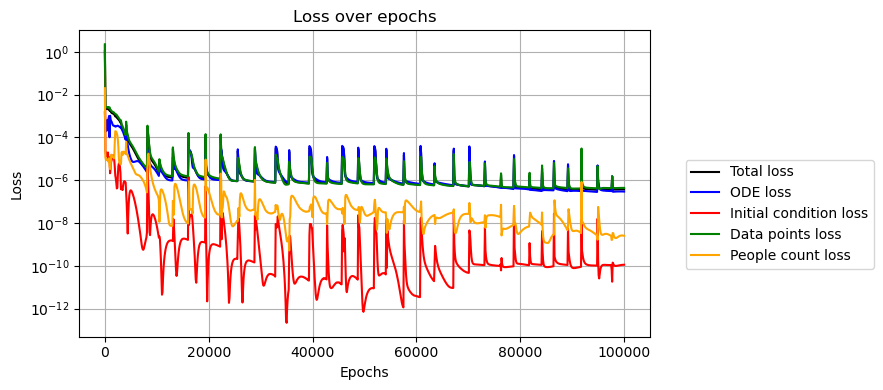

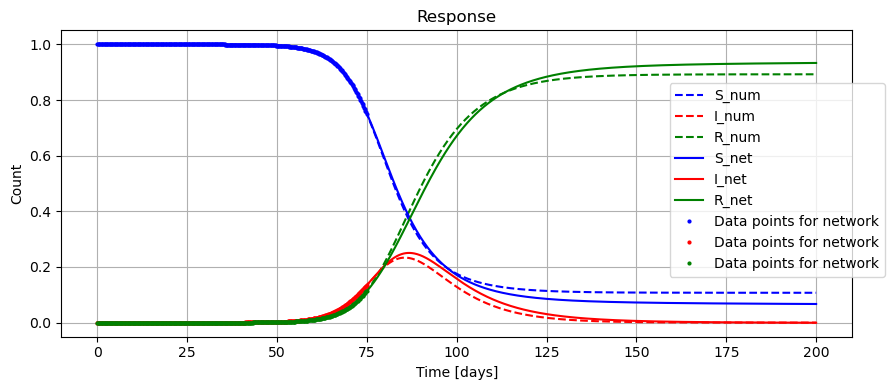

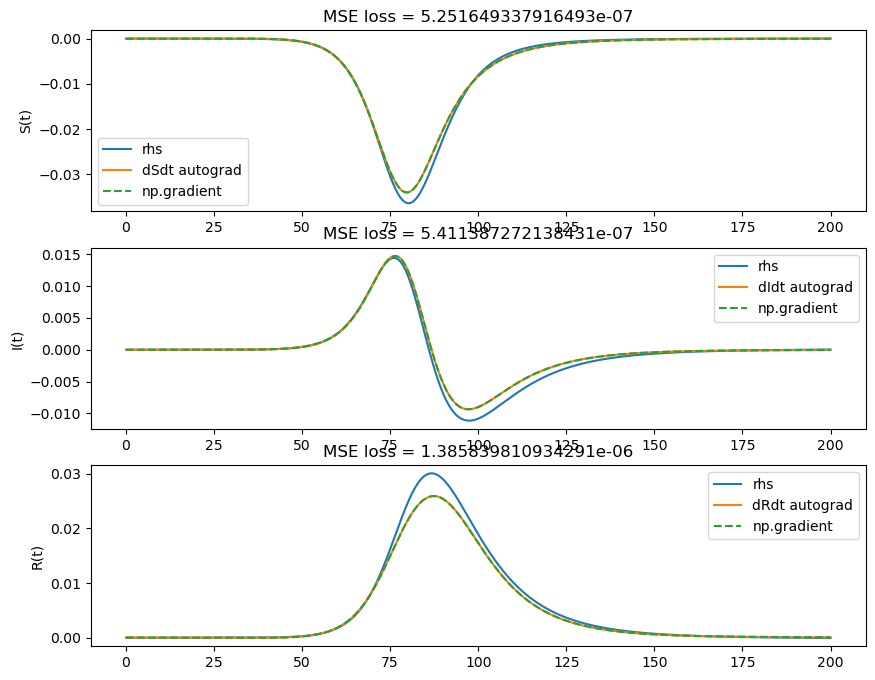

In [14]:
# Plot loss over epochs
fig, ax = plt.subplots(1, 1, figsize=(9,4))
ax.plot(epochs_saved[0:], loss_saved, color='k', label='Total loss')
ax.plot(epochs_saved[0:], loss_ode_saved, color='blue', label='ODE loss')
ax.plot(epochs_saved[0:], loss_ic_saved, color='red', label='Initial condition loss')
ax.plot(epochs_saved[0:], loss_data_saved, color='green', label='Data points loss')
ax.plot(epochs_saved[0:], loss_people_count_saved, color='orange', label='People count loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.set_title('Loss over epochs')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 0.6))
fig.tight_layout()

# Prepare t_num for network
net_cpu = net.to('cpu').eval()
t_num = t_num.view(-1,1).double() / n_days
S,I,R = net_cpu(t_num)
t_num = t_num * n_days

# Plot 
fig, ax = plt.subplots(1, 1, figsize=(9,4))
ax.plot(t_num.to('cpu').detach(), S_data.to('cpu').detach(), color='blue', linestyle='--', label='S_num')
ax.plot(t_num.to('cpu').detach(), I_data.to('cpu').detach(), color='red', linestyle='--', label='I_num')
ax.plot(t_num.to('cpu').detach(), R_data.to('cpu').detach(), color='green', linestyle='--', label='R_num')
ax.plot(t_num.to('cpu').detach(), S.to('cpu').detach(), color='blue', label='S_net')
ax.plot(t_num.to('cpu').detach(), I.to('cpu').detach(), color='red', label='I_net')
ax.plot(t_num.to('cpu').detach(), R.to('cpu').detach(), color='green', label='R_net')
ax.plot(t_data_points, S_data_points, linestyle='', marker='o', color='blue', label='Data points for network', markersize=2)
ax.plot(t_data_points, I_data_points, linestyle='', marker='o', color='red', label='Data points for network', markersize=2)
ax.plot(t_data_points, R_data_points, linestyle='', marker='o', color='green', label='Data points for network', markersize=2)
ax.set_xlabel('Time [days]')
ax.set_ylabel('Count')
ax.set_title('Response')
ax.grid()
ax.legend(bbox_to_anchor=(1.05, 0.85))
fig.tight_layout()


t_num = t_num.view(-1,1).double() / n_days
loss_ode, S, I, R, dSdt, dIdt, dRdt, rhs_S, rhs_I, rhs_R = get_loss_ode(t_num.requires_grad_(), net, beta_trainable.to('cpu'), alpha_trainable.to('cpu'))
t_num = t_num * n_days

# This plot plots the rhs and the lhs of the equations. This way we can see where the ODE loss is greater. 
# It also plots the np.gradient result to check we are calculating the gradint dSdt, dIdt, dRdt correctly.
fig, ax = plt.subplots(3, 1, figsize=(10,8))
ax[0].plot(t_num.detach(), -beta_SIR * S.detach() * I.detach())
ax[0].plot(t_num.detach(), dSdt.detach())
ax[0].plot(t_num.detach(), np.gradient(S.detach().numpy().reshape(-1), n_days/1000), linestyle='--')
ax[0].legend(['rhs', 'dSdt autograd', 'np.gradient'])
ax[0].set_title(f'MSE loss = {torch_MSE_loss(-beta_SIR * S.detach() * I.detach(), dSdt.detach())}')
ax[0].set_ylabel('S(t)')
ax[1].plot(t_num.detach(), beta_SIR * S.detach() * I.detach() - alpha_SIR * I.detach())
ax[1].plot(t_num.detach(), dIdt.detach())
ax[1].plot(t_num.detach(), np.gradient(I.detach().numpy().reshape(-1), n_days/1000), linestyle='--')
ax[1].legend(['rhs', 'dIdt autograd', 'np.gradient'])
ax[1].set_title(f'MSE loss = {torch_MSE_loss(beta_SIR * S.detach() * I.detach() - alpha_SIR * I.detach(), dIdt.detach())}')
ax[1].set_ylabel('I(t)')
ax[2].plot(t_num.detach(), alpha_SIR * I.detach())
ax[2].plot(t_num.detach(), dRdt.detach())
ax[2].plot(t_num.detach(), np.gradient(R.detach().numpy().reshape(-1), n_days/1000), linestyle='--')
ax[2].legend(['rhs', 'dRdt autograd', 'np.gradient'])
ax[2].set_title(f'MSE loss = {torch_MSE_loss(alpha_SIR * I.detach(), dRdt.detach())}')
ax[2].set_ylabel('R(t)')

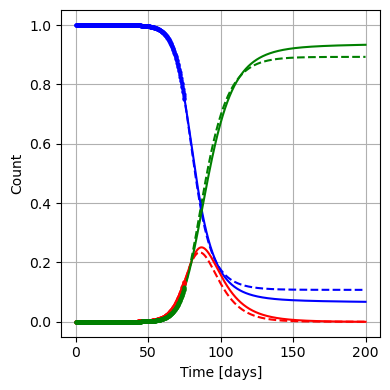

In [19]:
# Plot 
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(t_num.to('cpu').detach(), S_data.to('cpu').detach(), color='blue', linestyle='--', label='S_num')
ax.plot(t_num.to('cpu').detach(), I_data.to('cpu').detach(), color='red', linestyle='--', label='I_num')
ax.plot(t_num.to('cpu').detach(), R_data.to('cpu').detach(), color='green', linestyle='--', label='R_num')
ax.plot(t_num.to('cpu').detach(), S.to('cpu').detach(), color='blue', label='S_net')
ax.plot(t_num.to('cpu').detach(), I.to('cpu').detach(), color='red', label='I_net')
ax.plot(t_num.to('cpu').detach(), R.to('cpu').detach(), color='green', label='R_net')
ax.plot(t_data_points, S_data_points, linestyle='', marker='o', color='blue', label='Data points for network', markersize=2)
ax.plot(t_data_points, I_data_points, linestyle='', marker='o', color='red', label='Data points for network', markersize=2)
ax.plot(t_data_points, R_data_points, linestyle='', marker='o', color='green', label='Data points for network', markersize=2)
ax.set_xlabel('Time [days]')
ax.set_ylabel('Count')
#ax.set_title('Response')
ax.grid()
#ax.legend(bbox_to_anchor=(1.05, 0.85))
#ax.legend()
fig.tight_layout()

(0.0, 200.0)

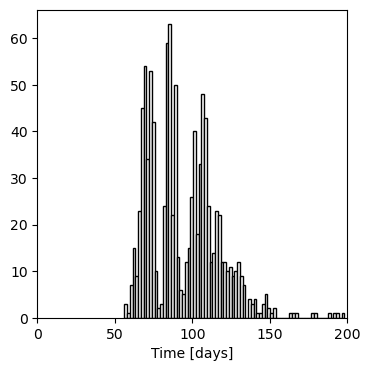

In [37]:
# Plot the distribution of sampling points
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.hist(t_train.to('cpu').detach().flatten(), bins=80, color='white', edgecolor='k')
ax.set_xlabel('Time [days]')
ax.set_xlim([0, 200])

The solver successfully reached the end of the integration interval.
tensor(2.1448e-10, dtype=torch.float64)
tensor(9.3201e-11, dtype=torch.float64)
tensor(1.0477e-10, dtype=torch.float64)


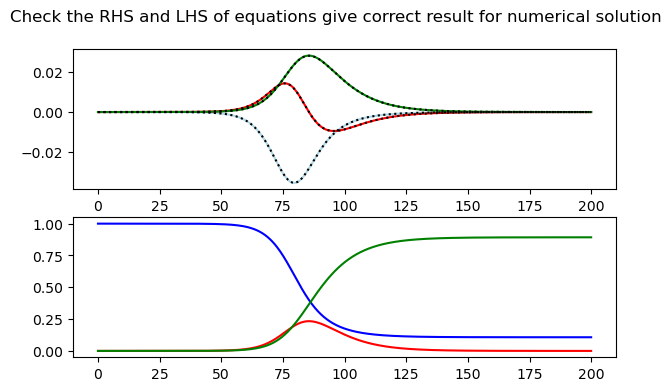

In [16]:
n_points = 1001

t_num = torch.linspace(0, n_days, n_points)

sol = solve_ivp(SIR_model_num, [t_num[0], t_num[-1]], y0, args=(beta_SIR, alpha_SIR), t_eval=t_num, method='LSODA')

S_data = torch.tensor(sol.y[0])
I_data = torch.tensor(sol.y[1])
R_data = torch.tensor(sol.y[2])
print(sol.message)

# Testing whether my brain is broken
dSdt_data = np.gradient(S_data, n_days/n_points)
dIdt_data = np.gradient(I_data, n_days/n_points)
dRdt_data = np.gradient(R_data, n_days/n_points)
rhs_S_data = -beta_SIR * S_data * I_data
rhs_I_data = beta_SIR * S_data * I_data - alpha_SIR * I_data
rhs_R_data = alpha_SIR * I_data

fig, ax = plt.subplots(2, 1, figsize=(7,4))
fig.suptitle('Check the RHS and LHS of equations give correct result for numerical solution')
ax[0].plot(t_num.detach(), dSdt_data, color='lightblue', linestyle='-', alpha=1)
ax[0].plot(t_num.detach(), dIdt_data, color='red', linestyle='-', alpha=1)
ax[0].plot(t_num.detach(), dRdt_data, color='green', linestyle='-', alpha=1)
ax[0].plot(t_num.detach(), rhs_S_data, color='k', linestyle=':')
ax[0].plot(t_num.detach(), rhs_I_data, color='k', linestyle=':')
ax[0].plot(t_num.detach(), rhs_R_data, color='k', linestyle=':')

ax[1].plot(t_num.detach(), S_data, color='blue')
ax[1].plot(t_num.detach(), I_data, color='red')
ax[1].plot(t_num.detach(), R_data, color='green')

# Print the residual
print(torch_MSE_loss(rhs_S_data.clone().detach(), torch.tensor(dSdt_data)))
print(torch_MSE_loss(rhs_I_data.clone().detach(), torch.tensor(dIdt_data)))
print(torch_MSE_loss(rhs_R_data.clone().detach(), torch.tensor(dRdt_data)))

tensor(5.2516e-07, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(5.1389e-07, dtype=torch.float64, grad_fn=<MseLossBackward0>)


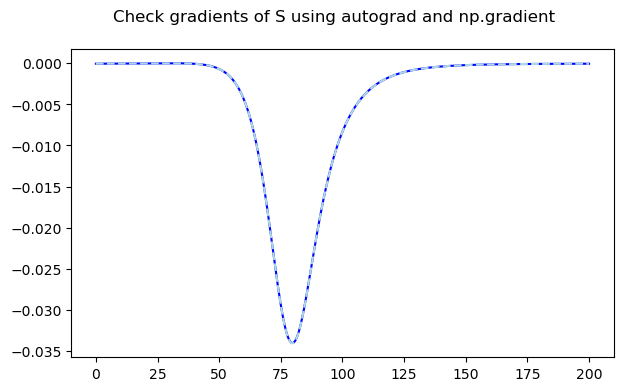

In [17]:
# Check that numpy.gradient gives same result as network through autograd
t = torch.linspace(0, n_days, n_points, requires_grad=True, dtype=torch.double).view(-1,1)
t = t / n_days
S_net, I_net, R_net = net_cpu(t)
dSdt_autograd =  1/n_days*torch.autograd.grad(S_net, t, grad_outputs=torch.ones_like(S_net), create_graph=True)[0]

t = t*n_days
dSdt_npgrad = np.gradient(S_net.detach().reshape(-1), n_days/n_points)

fig, ax = plt.subplots(1, 1, figsize=(7,4))
fig.suptitle('Check gradients of S using autograd and np.gradient')
ax.plot(t.detach(), dSdt_autograd.detach(), color='blue')
ax.plot(t.detach(), dSdt_npgrad, color='lightblue', linestyle='--')

print(torch_MSE_loss(dSdt_autograd, -beta_SIR * S_net * I_net))
print(torch_MSE_loss(torch.tensor(dSdt_npgrad).view(-1,1), -beta_SIR * S_net * I_net))

(0.0, 0.03)

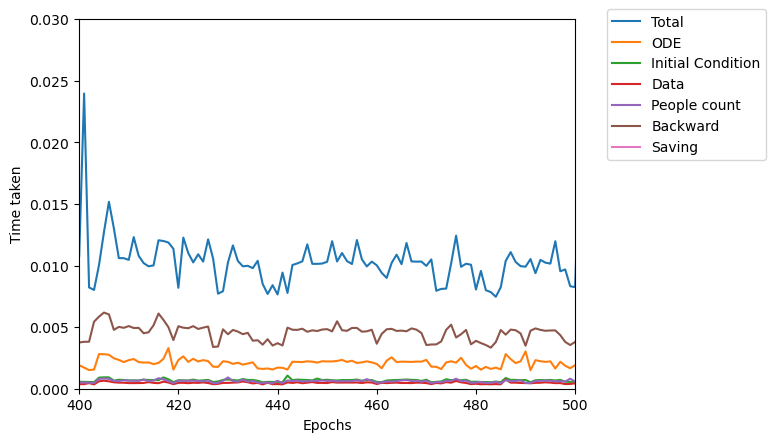

In [18]:
# Plotting time taken per iteration
fig, ax = plt.subplots(1,1)
ax.plot(time_total, label='Total')
ax.plot(time_ode, label='ODE')
ax.plot(time_ic, label='Initial Condition')
ax.plot(time_data, label='Data')
ax.plot(time_pc, label='People count')
ax.plot(time_backward, label='Backward')
ax.plot(time_save, label='Saving')
ax.legend(bbox_to_anchor=(1.05, 0.6))
ax.set_ylabel('Time taken')
ax.set_xlabel('Epochs')
ax.set_xlim(400,500)
ax.set_ylim(0,0.03)

Text(0.5, 0, 'Time [days]')

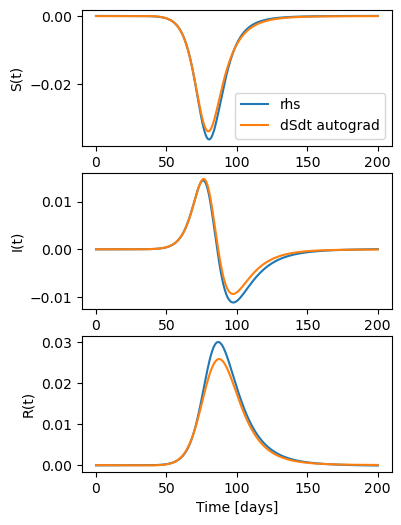

In [50]:
# This plot plots the rhs and the lhs of the equations. This way we can see where the ODE loss is greater. 
# It also plots the np.gradient result to check we are calculating the gradint dSdt, dIdt, dRdt correctly.
fig, ax = plt.subplots(3, 1, figsize=(4,6))
ax[0].plot(t_num.detach(), -beta_SIR * S.detach() * I.detach())
ax[0].plot(t_num.detach(), dSdt.detach())
#ax[0].plot(t_num.detach(), np.gradient(S.detach().numpy().reshape(-1), n_days/1000), linestyle='--')
ax[0].legend(['rhs', 'dSdt autograd'])
#ax[0].set_title(f'MSE loss = {torch_MSE_loss(-beta_SIR * S.detach() * I.detach(), dSdt.detach())}')
ax[0].set_ylabel('S(t)')
ax[1].plot(t_num.detach(), beta_SIR * S.detach() * I.detach() - alpha_SIR * I.detach())
ax[1].plot(t_num.detach(), dIdt.detach())
#ax[1].plot(t_num.detach(), np.gradient(I.detach().numpy().reshape(-1), n_days/1000), linestyle='--')
#ax[1].legend(['rhs', 'dIdt autograd', 'np.gradient'])
#ax[1].set_title(f'MSE loss = {torch_MSE_loss(beta_SIR * S.detach() * I.detach() - alpha_SIR * I.detach(), dIdt.detach())}')
ax[1].set_ylabel('I(t)')
ax[2].plot(t_num.detach(), alpha_SIR * I.detach())
ax[2].plot(t_num.detach(), dRdt.detach())
#ax[2].plot(t_num.detach(), np.gradient(R.detach().numpy().reshape(-1), n_days/1000), linestyle='--')
#ax[2].legend(['rhs', 'dRdt autograd', 'np.gradient'])
#ax[2].set_title(f'MSE loss = {torch_MSE_loss(alpha_SIR * I.detach(), dRdt.detach())}')
ax[2].set_ylabel('R(t)')
ax[2].set_xlabel('Time [days]')